# Demos: Lecture 16

In [9]:
import pennylane as qml
from pennylane import numpy as np
from itertools import chain

from lecture16_helpers import *

## Demo 1: QAOA from scratch

Our Hamiltonians:


\begin{equation*}
 \hat{H}_{c} =  \sum_{ij \in E} \left( Z_{i}  +  Z_{j} +
   Z_{i} Z_{j}\right) - 2 \sum_{i \in V}  Z_{i} 
\end{equation*}

\begin{equation*}
\hat{H}_{m} = \sum_{i} X_{i}
\end{equation*}

<img src="fig/qaoa.png">

In [36]:
edges = [(0, 1), (1, 2), (2, 3), (3, 0)]

edge_term_ops = [
    [qml.PauliZ(-i), qml.PauliZ(-j), qml.PauliZ(i) @ qml.PauliZ(j)]
    for (i, j) in edges
]
edge_term_ops = list(chain(*edge_term_ops))

edge_term_coeffs = [3] * len(edge_term_ops)

vertex_term_ops = [qml.PauliZ(i) for i in range(4)]
vertex_term_coeffs = [1] * len(vertex_term_ops)

In [37]:
H_edge = qml.Hamiltonian(edge_term_coeffs, edge_term_ops)
H_vertex = qml.Hamiltonian(vertex_term_coeffs, vertex_term_ops)
H_cost = H_edge + H_vertex

In [38]:
print(H_cost)

  (1) [Z1]
+ (1) [Z2]
+ (1) [Z3]
+ (6) [Z-1]
+ (6) [Z-2]
+ (6) [Z-3]
+ (7) [Z0]
+ (3) [Z0 Z1]
+ (3) [Z1 Z2]
+ (3) [Z2 Z3]
+ (3) [Z3 Z0]


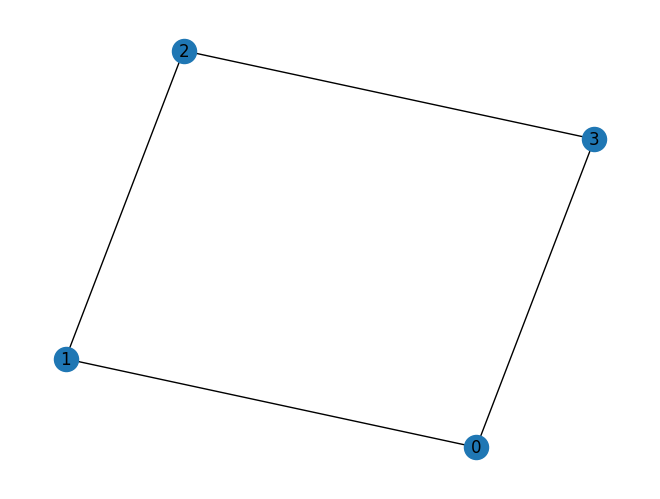

In [39]:
plot_graph(edges)

In [40]:
mixer_ops = [qml.PauliX(i) for i in range(5)]
mixer_coeffs = [1] * len(mixer_ops)

H_mixer = qml.Hamiltonian(mixer_coeffs, mixer_ops)

In [41]:
print(H_mixer)

  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]


In [42]:
dev = qml.device("default.qubit", wires=5)

n_layers = 5
alpha_m = np.random.normal(size=n_layers)
beta_c = np.random.normal(size=n_layers)

In [43]:
def qaoa_circuit(alpha_m, beta_c):
    for wire in range(5):
        qml.Hadamard(wires=wire)
        
    for layer_idx in range(n_layers):
        qml.ApproxTimeEvolution(H_cost, beta_c[layer_idx], 1)
        qml.ApproxTimeEvolution(H_mixer, alpha_m[layer_idx], 1)
        
@qml.qnode(dev)
def cost_function(alpha_m, beta_c):
    qaoa_circuit(alpha_m, beta_c)
    return qml.expval(H_cost)

@qml.qnode(dev)
def compute_probs(alpha_m, beta_c):
    qaoa_circuit(alpha_m, beta_c)
    return qml.probs(wires=range(5))

In [44]:
opt = qml.GradientDescentOptimizer(stepsize=0.01)

n_its = 100

for _ in range(n_its):
    alpha_m, beta_c = opt.step(cost_function, alpha_m, beta_c)

WireError: Did not find some of the wires (-1,) on device with wires (0, 1, 2, 3, 4).

In [ ]:
alpha_m

In [45]:
compute_probs(alpha_m, beta_c)

WireError: Did not find some of the wires (-1,) on device with wires (0, 1, 2, 3, 4).

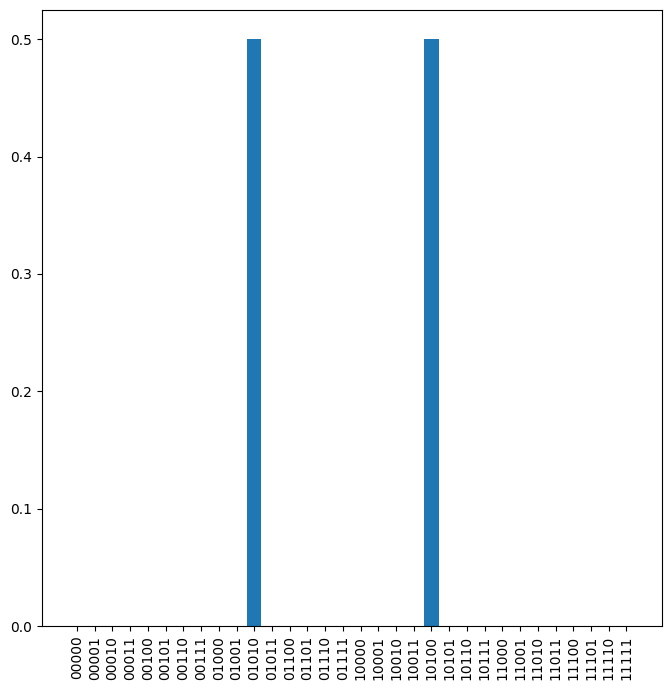

In [21]:
plot_probs(compute_probs(alpha_m, beta_c))

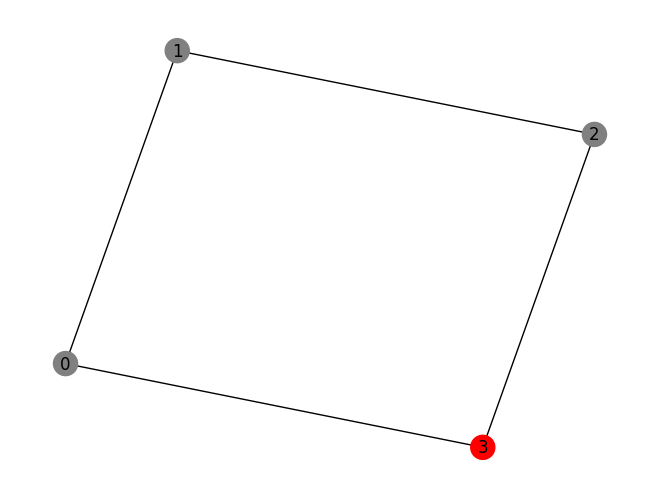

In [23]:
plot_graph(edges, solution_string="0001")